In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import import_ipynb
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from utils import *

2023-06-21 18:04:18.914547: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-21 18:04:19.052402: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 18:04:19.738504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


importing Jupyter notebook from utils.ipynb


In [2]:
df_train = pd.read_csv(train_csv_path, sep=",")
df_train["img_path"] =  df_train['image_id'].apply(build_image_path, convert_dtype=str)

df_test = pd.read_csv(test_csv_path, sep=",")
df_test["img_path"] =  df_test['image_id'].apply(build_image_path, convert_dtype=str)

In [3]:
# Vamos separar os dados em treinamento e validação na proporção 80/20:
df_train_split, df_val_split = train_test_split(df_train, test_size = 0.2, random_state = 123456, stratify = df_train[['cancer']])

print("Número de imagens no conjunto de treinamento: ", df_train_split.shape[0])
print("Distribuição de cancer conjunto de treinamento: ", df_train_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
print("Número de imagens no conjunto de validação: ", df_val_split.shape[0])
print("Distribuição de cancer no conjunto de validação: ", df_val_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
print("Número de imagens no conjunto de teste: ", df_test.shape[0])
print("Distribuição de cancer no conjunto de teste: ", df_test.groupby("cancer").agg(qtde=("site_id","count")).reset_index())

Número de imagens no conjunto de treinamento:  34995
Distribuição de cancer conjunto de treinamento:     cancer   qtde
0       0  34222
1       1    773
Número de imagens no conjunto de validação:  8749
Distribuição de cancer no conjunto de validação:     cancer  qtde
0       0  8556
1       1   193
Número de imagens no conjunto de teste:  10962
Distribuição de cancer no conjunto de teste:     cancer   qtde
0       0  10770
1       1    192


In [6]:
clean_all_datasets()

# Criando os diretórios:
create_dataset_dirs()
    
# Criando os subdiretórios
build_train_dataset_from_ori_imgs(df_train_split)
    
build_val_dataset_from_ori_imgs(df_val_split)

build_test_dataset_from_ori_imgs(df_test)

In [7]:
# Criando geradores de imagem para o tensorflow:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [8]:
class_names = ['normal', 'cancer']
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir_path,
    # classes = class_names,
    target_size = target_size,
    batch_size = 64,
    class_mode = 'binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_dir_path,
        # classes = class_names,
        target_size = target_size,
        batch_size = 64,
        class_mode = 'binary',
        subset='validation')

test_generator = test_datagen.flow_from_directory(
        test_dir_path,
        # classes = class_names,
        target_size = target_size,
        batch_size = 64,
        class_mode = 'binary')

Found 34995 images belonging to 2 classes.
Found 8749 images belonging to 2 classes.
Found 10962 images belonging to 2 classes.


In [9]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model


model_resnet50 = ResNet50V2(weights = 'imagenet', input_shape = (target_size[0], target_size[1], 3), include_top = False)

for layer in model_resnet50.layers:
    layer.trainable = False
    
# build the entire model
x = model_resnet50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs = model_resnet50.input, outputs = predictions)

model.summary()



2023-06-21 18:04:36.427277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-21 18:04:36.921551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-21 18:04:36.921672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
%load_ext tensorboard
from datetime import datetime

logs_dir = '/home/kasco/MDC/FinalProject/BreastCancerDetection/logs/baseline_resnet'

logdir = os.path.join(logs_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [10]:
from keras.optimizers import SGD, Adam

early_stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 20, )
save_model = tf.keras.callbacks.ModelCheckpoint(filepath = '../weights/baseline_resnet/weights.{epoch:02d}-{val_loss:.2f}.h5', monitor = "val_loss", mode = "min", save_best_only = True)

def trainModel(model, epochs, optimizer, callbacks = []):
    batch_size = 64
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator,
                     validation_data=validation_generator,
                      epochs=epochs,
                      steps_per_epoch = train_generator.samples // batch_size,
                      validation_steps = validation_generator.samples // batch_size,
                      batch_size=batch_size,
                      callbacks=callbacks)

sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
adam =  Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_history = trainModel(model = model, epochs = 500, optimizer = sgd, callbacks = [early_stopper, save_model, tensorboard_callback])

Epoch 1/120


2023-06-21 18:04:39.547544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-21 18:04:42.418578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-21 18:04:43.217629: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-21 18:04:43.570359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-21 18:04:45.174463: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f30eb79cb90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-21 18:04:45.174488: I tensorflo

1094/1094 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9759

2023-06-21 18:08:12.358506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1094/1094 [==============================] - 270s 241ms/step - loss: 0.1367 - accuracy: 0.9759 - val_loss: 0.1136 - val_accuracy: 0.9779
Epoch 2/120
1094/1094 [==============================] - 263s 240ms/step - loss: 0.1129 - accuracy: 0.9779 - val_loss: 0.1060 - val_accuracy: 0.9779
Epoch 3/120
1094/1094 [==============================] - 260s 238ms/step - loss: 0.1112 - accuracy: 0.9779 - val_loss: 0.1061 - val_accuracy: 0.9779
Epoch 4/120
1094/1094 [==============================] - 262s 240ms/step - loss: 0.1119 - accuracy: 0.9779 - val_loss: 0.1061 - val_accuracy: 0.9779
Epoch 5/120
1094/1094 [==============================] - 262s 239ms/step - loss: 0.1122 - accuracy: 0.9779 - val_loss: 0.1061 - val_accuracy: 0.9779
Epoch 6/120
1094/1094 [==============================] - 262s 240ms/step - loss: 0.1099 - accuracy: 0.9779 - val_loss: 0.1060 - val_accuracy: 0.9779
Epoch 7/120
1094/1094 [==============================] - 262s 239ms/step - loss: 0.1107 - accuracy: 0.9779 - val_loss:

In [11]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

Text(0, 0.5, 'loss')

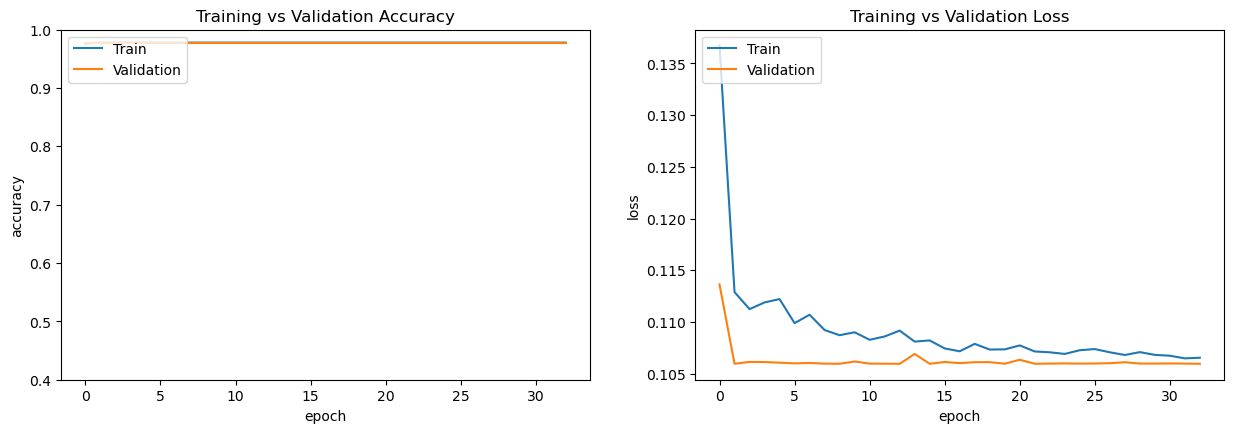

In [12]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

2023-06-21 20:29:32.156978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


343/343 [==============================] - 64s 185ms/step


Text(50.722222222222214, 0.5, 'Real')

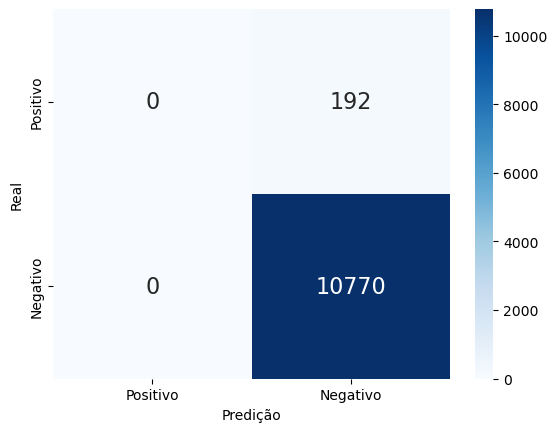

In [13]:
model_resnet50 = load_model('baseline_resnet50.h5')

pred_resnet50 = model_resnet50.predict(test_generator)

y_pred_resnet50 = []
for prob in pred_resnet50:
    if prob >= 0.5:
        y_pred_resnet50.append(1)
    else:
        y_pred_resnet50.append(0)
        
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_resnet50)

class_names = ['Positivo', 'Negativo']

ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

ax.set_xlabel("Predição")
ax.set_ylabel("Real")